In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (15,9)

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import NMF
from pathlib import Path

from analysis import analysis # this works because same package
from utils import utils, files # sibling package...

# protocol

1. record calibration dataset and extract per-channel variances
2. do PCA on the variance-scaled calibration dataset in order for PCs to not be contaminated by channel scales and choose PCs to make a linear decoder
3. in the center-hold-reach-out task, scale each incoming EMG channel by its calibration variance
4. project center-hold samples onto decoder PCs (and subsequently filter)

TODO:

- add scaling to bonsai for center-hold task
  - pick up scaling array from python / subject folder `variance.bin`
  - this is a diagonal matrix `np.diag(vars)`

NOTES:

- variances in natural movement task are not always similar to that of the calibration, so we opt not to scale the calibration task by the natural movement task
- one option to deal with "loud" channels is to keep a running variance and scale this way

In [2]:
def build_experiment_path_dict(experiment):
    data_folder = get_experiment_data_folder(experiment)
    subjects = [x.name for x in data_folder.iterdir() if x.name[0] != "."]
    path_dictionary = {"subjects":{}}
    for subject in subjects:
        subject_folder = data_folder / subject
        path_dictionary["subjects"].update({subject:{}})
        path_dictionary["subjects"][subject].update({"path" : subject_folder})
        tasks = [x.name for x in subject_folder.iterdir() if x.name[0] != "."]
        path_dictionary["subjects"][subject].update({"tasks": {}})
        for task in tasks:
            path_dictionary["subjects"][subject]["tasks"].update({task : {"path" : subject_folder/task}})
            session_paths = sorted([x for x in (subject_folder/task).iterdir() if x.name[0] != "."],key=lambda x:x.name[-1])
            session_names = [x.name for x in session_paths]
            path_dictionary["subjects"][subject]["tasks"][task].update({"sessions": {}})
            for path, session in zip(session_paths,session_names):
                path_dictionary["subjects"][subject]["tasks"][task]["sessions"].update({session : path})
    return path_dictionary

def get_experiment_data_folder(experiment):
    if sys.platform == "linux":
        base_data_folder = Path("/mnt/c/Users/spencer/data/")
    else:
        base_data_folder = Path("/Users/spencerw/data/")
    experiment_data_folder = base_data_folder / experiment
    assert experiment_data_folder.exists(
    ), f"Path {experiment_data_folder} not found"
    print("data folder: ", experiment_data_folder)
    return experiment_data_folder


def get_session_path(d, subject, task, session):
    return d["subjects"][subject]["tasks"][task]["sessions"][session]

def load_movement_emg(session_path, movement=None):
    data = {}
    paths = sorted([x for x in session_path.iterdir() if x.suffix == ".bin"],key=str)
    for p in paths:
        name = p.name.rstrip(".bin")[:-17]
        data[name] = np.fromfile(p,dtype=np.int32).reshape(-1,68)
    if movement is None:
        return data
    else:
        return data[movement]

def load_calibration_emg(session_path, channel=None):
    data = {}
    # paths = sorted([x for x in session_path.iterdir() if x.suffix == ".bin" and not "V" in x.name])
    paths = sorted([x for x in session_path.iterdir() if x.suffix == ".bin" and "emg" in x.name])
    for p in paths:
        prefix = files.parse_filename_prefix(p)
        data[str(prefix)] = np.fromfile(p,dtype=np.int32).reshape(-1,68)
    if channel is None:
        return data
    else:
        return data[channel]

def load_calibration_filtered(session_path, channel=None):
    data = {}
    # paths = sorted([x for x in session_path.iterdir() if x.suffix == ".bin" and not "V" in x.name])
    paths = sorted([x for x in session_path.iterdir() if x.suffix == ".bin" and "filtered" in x.name])
    for p in paths:
        prefix = files.parse_filename_prefix(p)
        data[str(prefix)] = np.fromfile(p,dtype=np.int32).reshape(-1,68)
    if channel is None:
        return data
    else:
        return data[channel]

def load_center_hold_emg(session_path, channel=None):
    data = {}
    paths = sorted([x for x in session_path.iterdir() if "emg" in x.name and not "filtered" in x.name and x.suffix == ".bin"], key=files.parse_filename_prefix)
    for p in paths:
        prefix = files.parse_filename_prefix(p)
        data[str(prefix)] = np.fromfile(p,dtype=np.int32).reshape(-1,68)
    if channel is None:
        return data
    else:
        return data[channel]

def concat_emg_trials(session_dict):
    return np.vstack(list(session_dict.values()))

# load data

In [3]:
experiment = "self_test_9_2_21"
subject = "peter"

movement_session = "0"
calibration_session = "0"
center_hold_session = "3"

In [4]:
ed = build_experiment_path_dict(experiment)

if not movement_session is None:
    path = get_session_path(ed, subject, "natural_movement", "session_" + str(movement_session))
    print("movement: ", path)
    md = load_movement_emg(path)
    print("movement: ", md.keys())

if not calibration_session is None:
    path = get_session_path(ed, subject, "calibration_bars", "session_" + str(calibration_session))
    print("calibration: ", path)
    cd = load_calibration_emg(path)
    print("calibration: ", cd.keys())

if not center_hold_session is None:
    path = get_session_path(ed, subject, "center_hold", "session_" + str(center_hold_session))
    print(path)
    chd = load_center_hold_emg(path)
    print("center hold: ", chd.keys())

data folder:  /mnt/c/Users/spencer/data/self_test_9_2_21
movement:  /mnt/c/Users/spencer/data/self_test_9_2_21/peter/natural_movement/session_0
movement:  dict_keys(['hand closed', 'hand open', 'index finger down', 'index finger up', 'little finger down', 'little finger up', 'middle finger down', 'middle finger up', 'ring finger down', 'ring finger up', 'wrist down', 'wrist in', 'wrist out', 'wrist up'])
calibration:  /mnt/c/Users/spencer/data/self_test_9_2_21/peter/calibration_bars/session_0
calibration:  dict_keys(['0', '11', '13', '15', '16', '18', '20', '22', '25', '27', '29', '2', '31', '32', '34', '36', '38', '41', '43', '45', '47', '48', '4', '50', '52', '54', '57', '59', '61', '63', '6', '9'])
/mnt/c/Users/spencer/data/self_test_9_2_21/peter/center_hold/session_3
center hold:  dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])


# filter and compute variance

In [5]:
high_cutoff = 5

if not movement_session is None:
    movement_data = concat_emg_trials(md)[:,:64]
    movement_data = analysis.highpass(movement_data,cutoff=high_cutoff)
    print(movement_data.shape)
    movement_vars = np.std(movement_data, axis=0)
    movement_means = np.mean(movement_data, axis=0)

if not calibration_session is None:
    calibration_data = concat_emg_trials(cd)[:,:64]
    calibration_data = analysis.highpass(calibration_data,cutoff=high_cutoff)
    print(calibration_data.shape)
    calibration_vars = np.std(calibration_data, axis=0)
    calibration_means = np.mean(calibration_data, axis=0)

if not center_hold_session is None:
    center_hold_data = concat_emg_trials(chd)[:,:64]
    center_hold_data = analysis.highpass(center_hold_data,cutoff=high_cutoff)
    print(center_hold_data.shape)
    center_hold_vars = np.std(center_hold_data, axis=0)
    center_hold_means = np.mean(center_hold_data, axis=0)


(252000, 64)
(768000, 64)
(99230, 64)


# inspect data

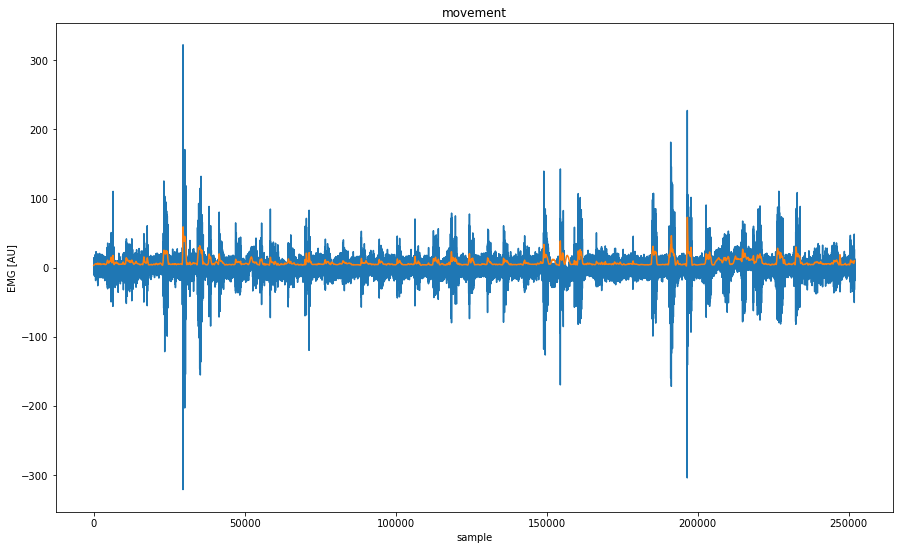

In [6]:
# plot one trial

low_cutoff = 5
start = 0
stop = -1
channel = 53

if not movement_session is None:
    plt.figure()
    hp = movement_data[start:stop,channel]
    plt.plot(hp)
    filtered_movement_data = analysis.lowpass(analysis.rectify(hp), cutoff=low_cutoff)
    plt.plot(filtered_movement_data)
    plt.title("movement")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")


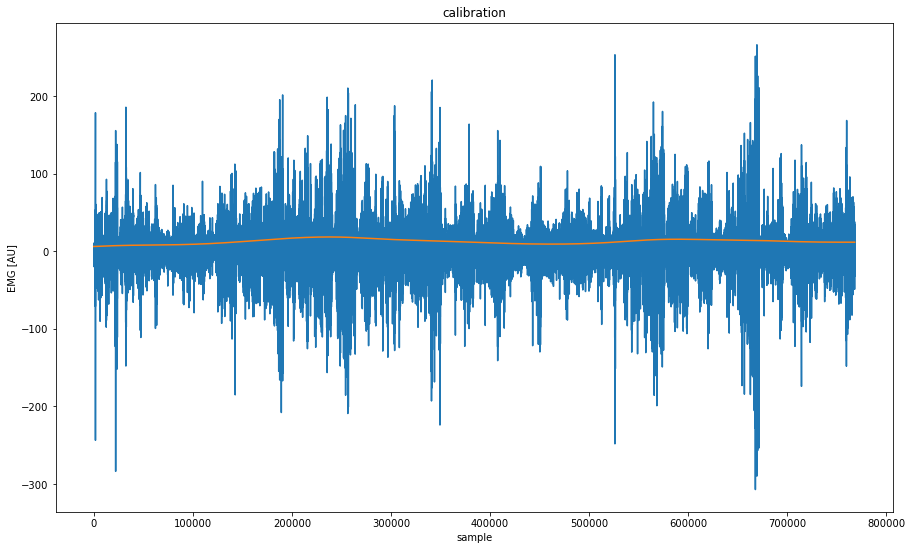

In [7]:

if not calibration_session is None:
    plt.figure()
    hp = calibration_data[start:stop,channel]
    lp = analysis.lowpass(analysis.rectify(hp), cutoff=0.01)
    plt.plot(hp)
    plt.plot(lp)
    plt.title("calibration")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")


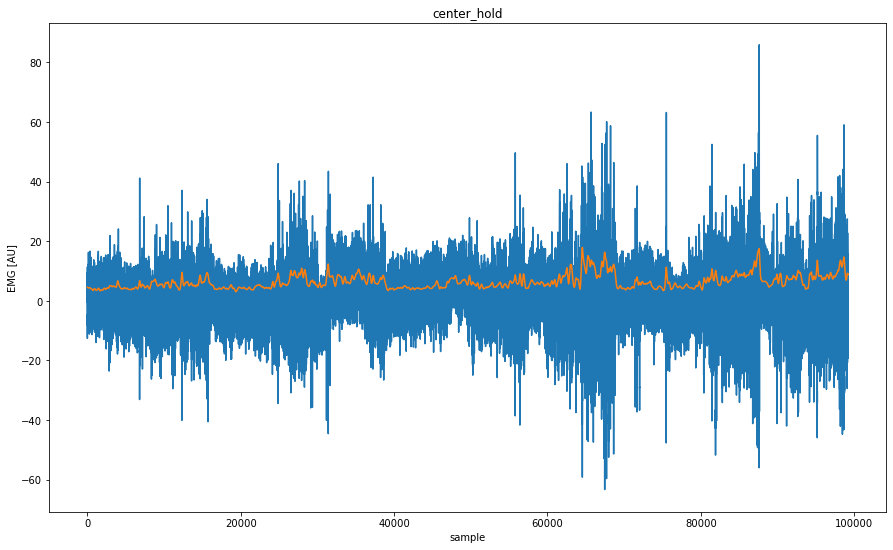

In [8]:
if not center_hold_session is None:
    plt.figure()
    hp = center_hold_data[start:stop,channel]
    lp_rectify = analysis.lowpass(analysis.rectify(hp), cutoff=low_cutoff)
    plt.plot(hp)
    plt.plot(lp_rectify)
    plt.title("center_hold")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")

# inspect mean and var

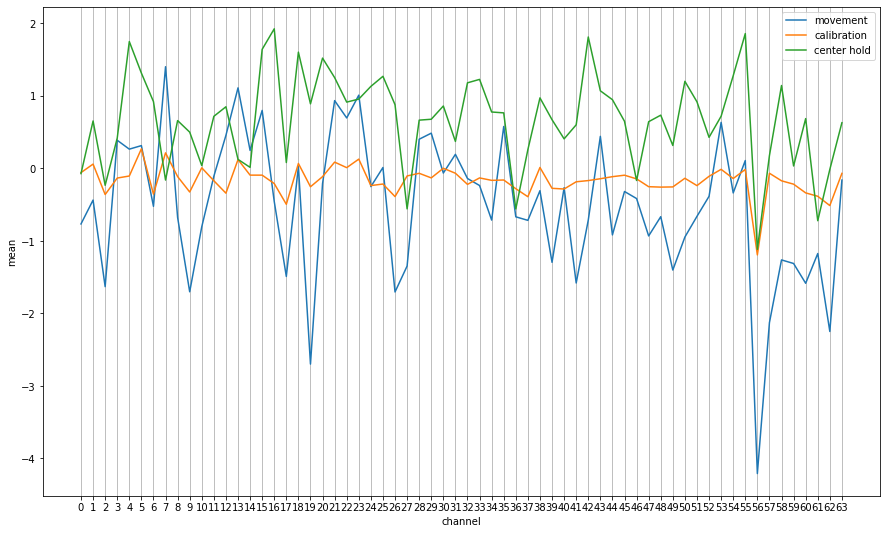

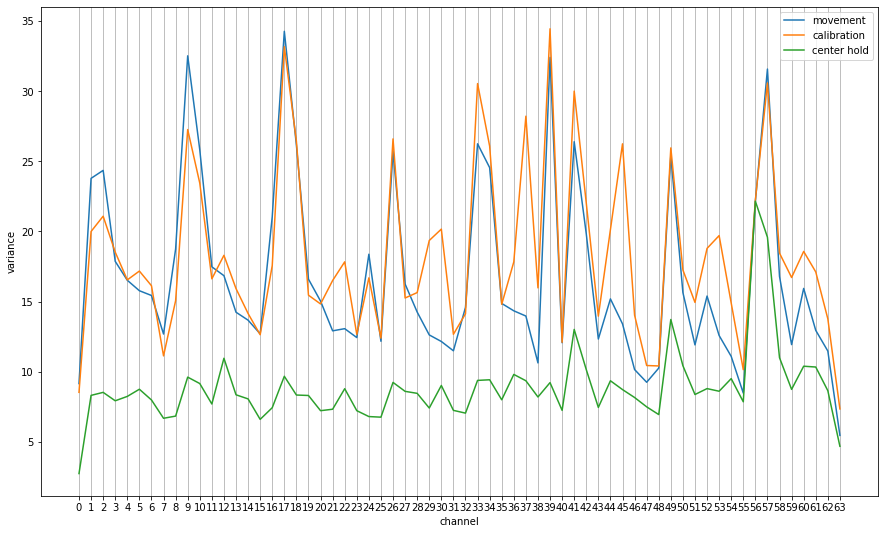

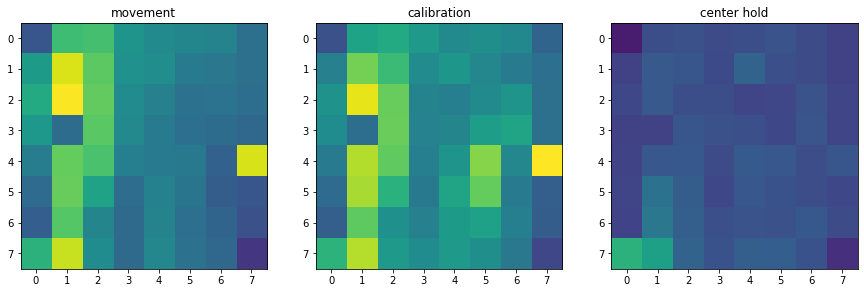

In [9]:
# mean
plt.figure()
if not movement_session is None:
    plt.plot(movement_means, label="movement")
if not calibration_session is None:
    plt.plot(calibration_means, label="calibration")
if not center_hold_session is None:
    plt.plot(center_hold_means, label="center hold")
plt.xticks(range(64))
plt.grid(which="both", axis="x")
plt.xlabel("channel")
plt.ylabel("mean")
plt.legend()

# variance
plt.figure()
if not movement_session is None:
    plt.plot(movement_vars, label="movement")
if not calibration_session is None:
    plt.plot(calibration_vars, label="calibration")
if not center_hold_session is None:
    plt.plot(center_hold_vars, label="center hold")
plt.xticks(range(64))
plt.grid(which="both", axis="x")
plt.xlabel("channel")
plt.ylabel("variance")
plt.legend()

maxes = []
if not movement_session is None:
    maxes.append(np.max(movement_vars))
if not calibration_session is None:
    maxes.append(np.max(calibration_vars))
if not center_hold_session is None:
    maxes.append(np.max(center_hold_vars))

maxmax = np.max(maxes)

fig, axes = plt.subplots(1,3)
if not movement_session is None:
    axes[0].imshow(movement_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[0].set_title("movement")
if not calibration_session is None:
    axes[1].imshow(calibration_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[1].set_title("calibration")
if not center_hold_session is None:
    axes[2].imshow(center_hold_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[2].set_title("center hold")

# save variance

In [10]:
v = np.diag(np.array(calibration_vars**-1, dtype=np.float32))
print(v)
print(v.shape)

# save decoder
subject_metadata_folder = utils.get_subject_folder(experiment="self_test", subject=subject)
assert subject_metadata_folder.exists()
utils.write_array_to_disk(a=v,path=subject_metadata_folder/"variance.bin")

[[0.11725014 0.         0.         ... 0.         0.         0.        ]
 [0.         0.05002892 0.         ... 0.         0.         0.        ]
 [0.         0.         0.0474403  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.05845053 0.         0.        ]
 [0.         0.         0.         ... 0.         0.07263862 0.        ]
 [0.         0.         0.         ... 0.         0.         0.13614804]]
(64, 64)


# standardize

In [11]:
# scale by movement dataset
def standardize(a, s):
    assert a.shape[1] == s.shape[0]
    standardized = np.divide(a, s)
    print(standardized.shape)
    return standardized

standardized_calibration_data = standardize(calibration_data, calibration_vars)

(768000, 64)


# filter

In [12]:
def filter(a, cutoff=5):
    filtered = analysis.lowpass(analysis.rectify(a.T), cutoff=cutoff).T
    print(np.min(filtered),np.max(filtered))
    filtered = analysis.rectify(filtered)
    print(np.min(filtered),np.max(filtered))
    print(filtered.shape)
    return filtered

filtered_calibration_data = filter(standardized_calibration_data)

-0.004793738725040256 6.315844616488823
0.00012911371163592224 6.315844616488823
(768000, 64)


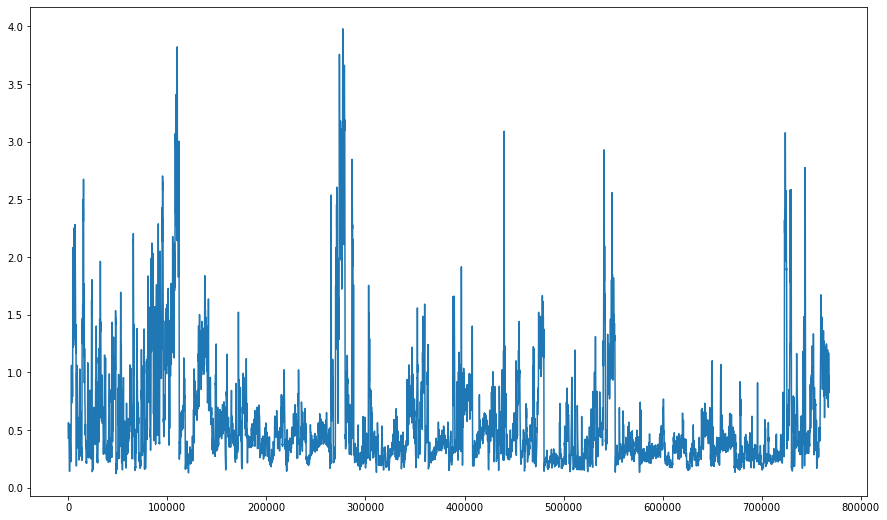

In [13]:
p = plt.plot(filtered_calibration_data[:,42])

(252000, 64)
0.025080543159973028 6.751110079889622
0.025080543159973028 6.751110079889622
(252000, 64)


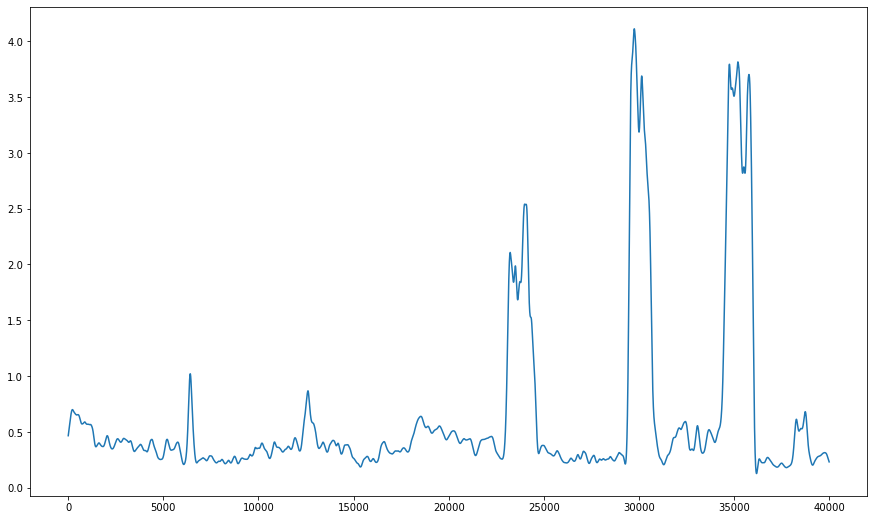

In [14]:
standardized_movement_data = standardize(movement_data, calibration_vars)
filtered_movement_data = filter(standardized_movement_data)
p = plt.plot(filtered_movement_data[:40000,42])

(1000, 64)
(1000, 64)
(1000, 64)


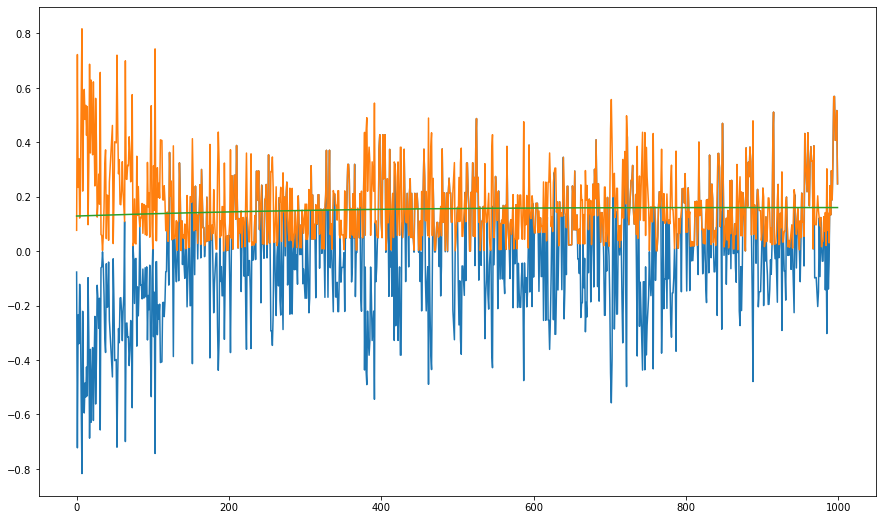

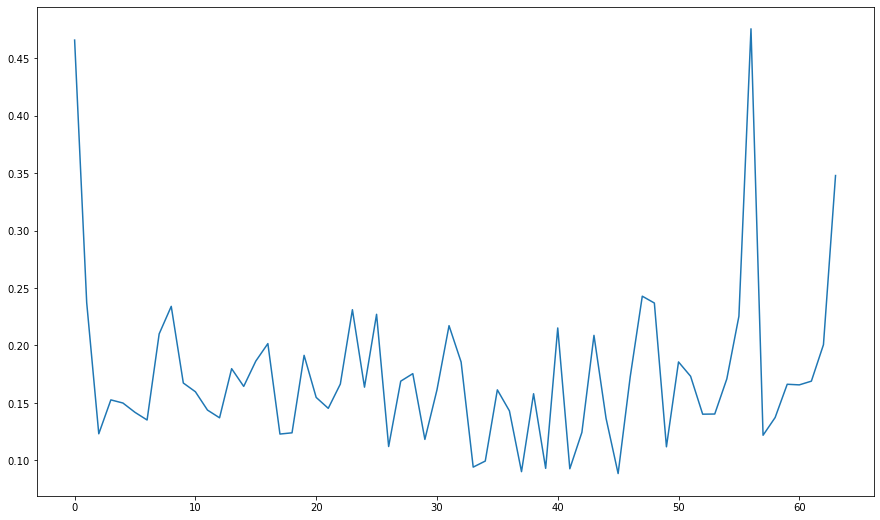

In [48]:
# extract rest portions of movement data

def load_movement_cue(session_path, movement=None):
    data = {}
    paths = sorted([x for x in session_path.iterdir() if "cue" in x.name],key=str)
    for p in paths:
        name = p.name.rstrip(".bin")[:-28]
        data[name] = np.genfromtxt(str(p), delimiter=',')[:,2].reshape(-1,1)
    if movement is None:
        return data
    else:
        return data[movement]

path = get_session_path(ed, subject, "natural_movement", "session_" + str(movement_session))
data = load_movement_cue(path)

cue = data["index finger up"]
signal = analysis.highpass(md["index finger up"].T,cutoff=3).T[:,:64]
signal = np.divide(signal, calibration_vars)
quiescent = signal[:1000]
print(quiescent.shape)
r = analysis.rectify(quiescent)
print(r.shape)
lp = analysis.lowpass(r.T,cutoff=1).T
print(lp.shape)
channel = 3
plt.figure()
plt.plot(quiescent[:,channel])
plt.plot(r[:,channel])
plt.plot(lp[:,channel])

offsets = np.mean(lp,axis=0).reshape(64,-1)
plt.figure()
plt.plot(offsets)

cue_interp = np.interp(np.linspace(0,cue.shape[0],signal.shape[0],endpoint=True), np.arange(cue.shape[0]), cue[:,0])

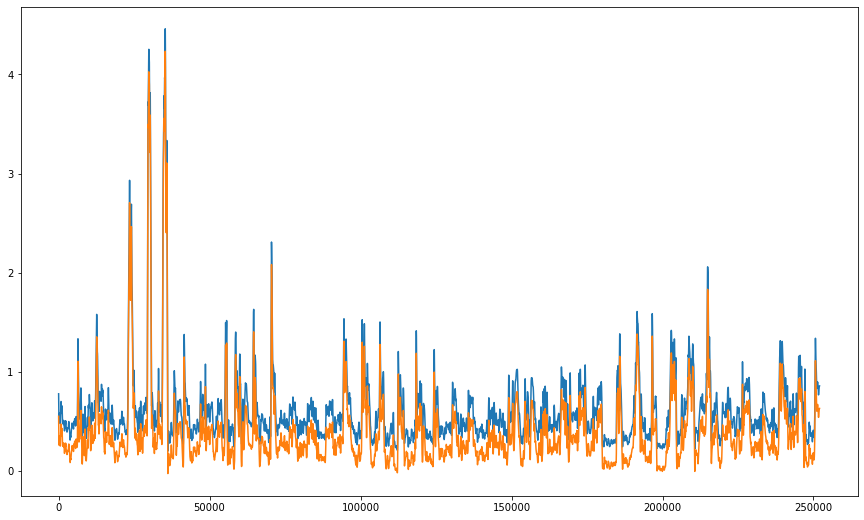

In [50]:
plt.figure()
plt.plot(filtered_movement_data[:,25])
plt.plot(np.subtract(filtered_movement_data,offsets.T)[:,25])

(99230, 64)
0.059894422713499 2.5478818726195187
0.059894422713499 2.5478818726195187
(99230, 64)


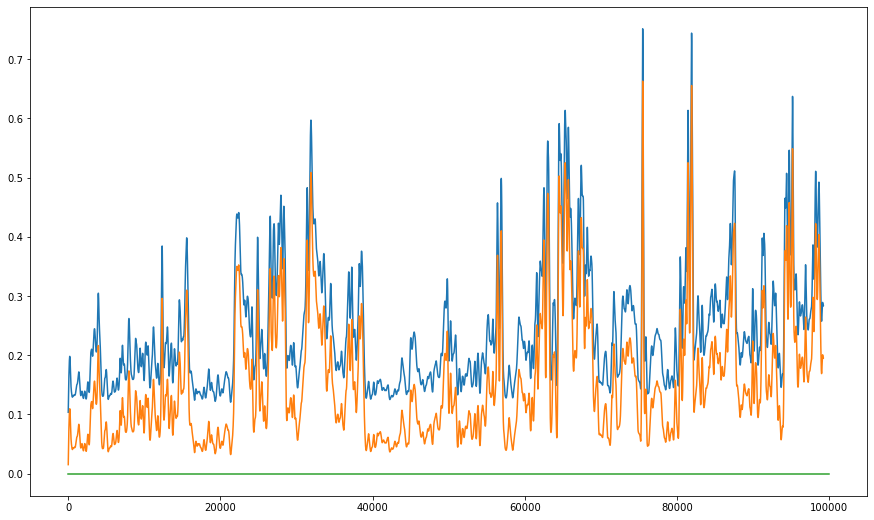

In [51]:
standardized_center_hold_data = standardize(center_hold_data, calibration_vars)
filtered_center_hold_data = filter(standardized_center_hold_data)
p = plt.plot(filtered_center_hold_data[:,45])
p = plt.plot(np.subtract(filtered_center_hold_data[:,45],offsets[45,0]))
plt.plot([0,1e5],[0,0])

# NMF

In [19]:
num_nmf_components = 8
nmf_model = NMF(n_components=num_nmf_components, max_iter=500, l1_ratio=0.3, regularization="transformation")
nmf_model.fit(filtered_calibration_data)
nmf_components = nmf_model.components_
print(nmf_components.shape)

/home/spencer/miniconda3/envs/motor/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/spencer/miniconda3/envs/motor/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


(8, 64)


In [20]:
norms = np.linalg.norm(nmf_components,axis=1).reshape(num_nmf_components,1)
print(norms)
normalized_nmf_components = np.divide(nmf_components, norms)
normalized_nmf_components.shape

[[37.66299399]
 [34.79509651]
 [31.2648457 ]
 [36.91407311]
 [23.45566593]
 [30.09509495]
 [55.59084463]
 [25.39806516]]


(8, 64)

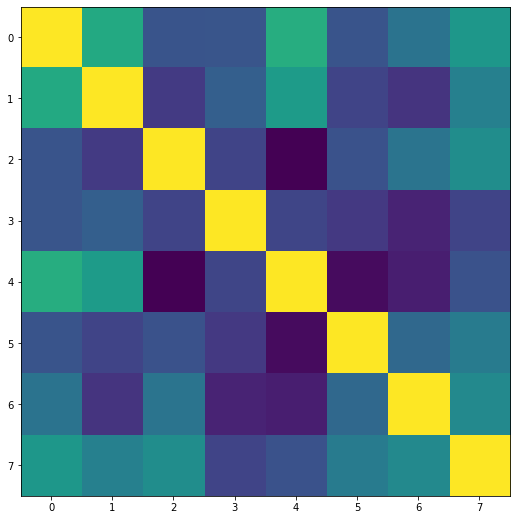

In [25]:
# mode covariance
plt.imshow(normalized_nmf_components@normalized_nmf_components.T)

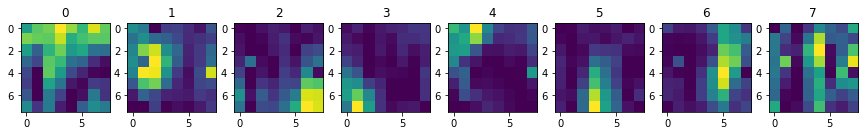

In [26]:
fig, axes = plt.subplots(1,num_nmf_components)
for i, (ax, c) in enumerate(zip(axes,normalized_nmf_components)):
    ax.imshow(c.reshape(8,8))
    ax.set_title(i)

In [30]:
component_idxs = [1,2,3,4]

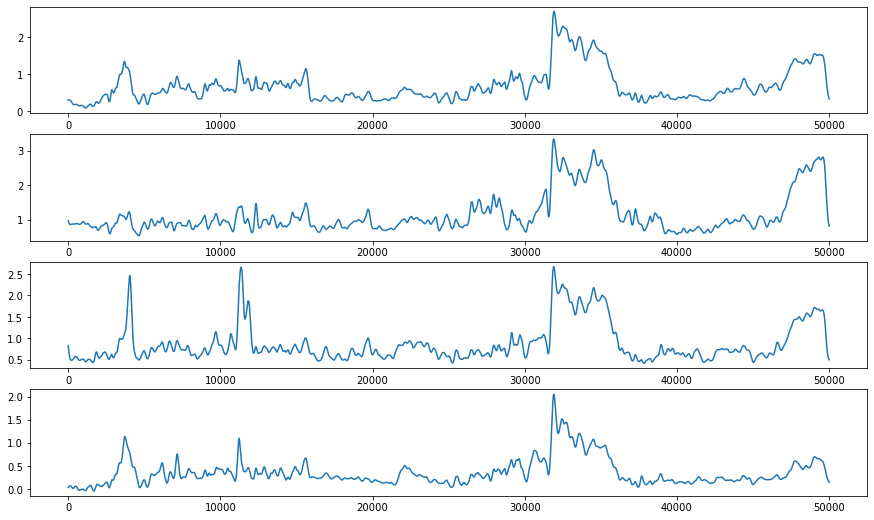

In [35]:
fig, axes = plt.subplots(len(component_idxs),1)
for ax, c in zip(axes,normalized_nmf_components[component_idxs]):
    baseline = np.dot(c,filtered_center_hold_data.T-offsets)
    ax.plot(baseline[0:50000])

(-2.0, 2.0)

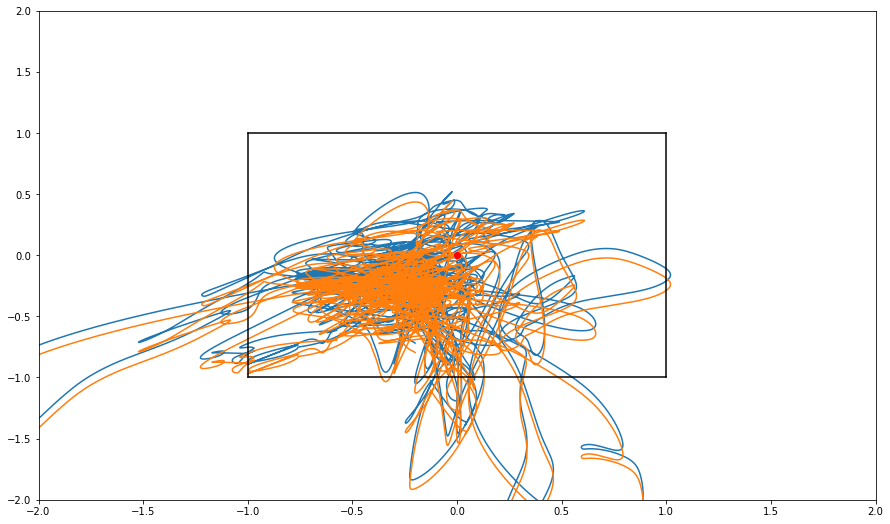

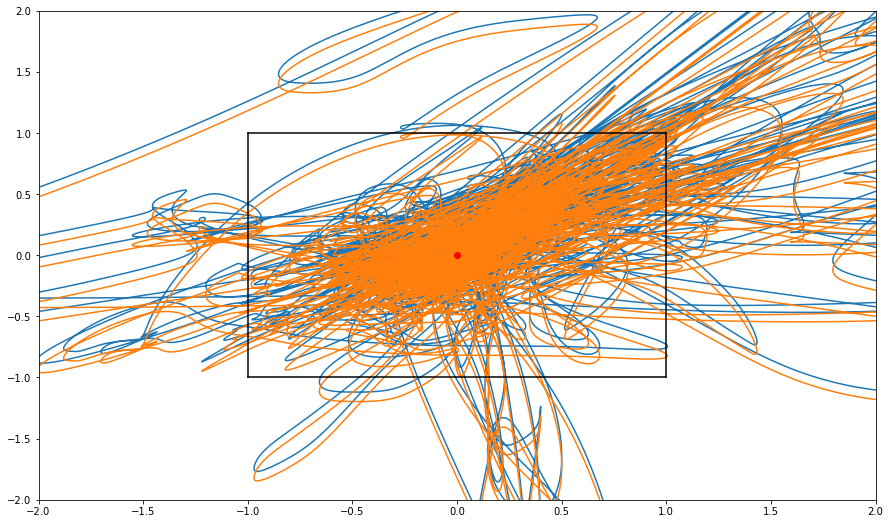

In [52]:
up = normalized_nmf_components[component_idxs[0]] - normalized_nmf_components[component_idxs[1]]
right = normalized_nmf_components[component_idxs[3]] - normalized_nmf_components[component_idxs[2]]
plt.figure()
plt.plot(np.dot(up,filtered_center_hold_data.T),np.dot(right,filtered_center_hold_data.T))
plt.plot(np.dot(up,filtered_center_hold_data.T),np.dot(right,filtered_center_hold_data.T-offsets))
plt.plot(0,0,'ro')
plt.plot([-1,1],[-1,-1],"k")
plt.plot([-1,1],[1,1],"k")
plt.plot([1,1],[-1,1],"k")
plt.plot([-1,-1],[-1,1],"k")
plt.xlim([-2,2])
plt.ylim([-2,2])

plt.figure()
plt.plot(np.dot(up,filtered_movement_data.T),np.dot(right,filtered_movement_data.T))
plt.plot(np.dot(up,filtered_movement_data.T),np.dot(right,filtered_movement_data.T-offsets))
plt.plot(0,0,'ro')
plt.plot([-1,1],[-1,-1],"k")
plt.plot([-1,1],[1,1],"k")
plt.plot([1,1],[-1,1],"k")
plt.plot([-1,-1],[-1,1],"k")
plt.xlim([-2,2])
plt.ylim([-2,2])

# PCA

In [ ]:
# get components -- channel-wise covariance
num_components = 3
pca_model = PCA(n_components=num_components)
pca_model.fit(filtered_calibration_data)
pca_components = pca_model.components_
print(pca_components.shape)

In [ ]:
# screeplots
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(1,num_components+1), pca_model.explained_variance_ratio_)
ax1.set_ylabel("explained_variance")
ax1.set_xlabel("component")

ax2.plot(range(1,num_components+1), pca_model.singular_values_)
ax2.set_ylabel("singular value")
ax2.set_xlabel("component")

# choose components
fig, axes = plt.subplots(1,num_components,figsize=(18,6))
for i, ax in enumerate(axes):
    ax.imshow(pca_components[i].reshape(8,8),vmin=np.min(pca_components),vmax=np.max(pca_components))
    ax.set_title(str(i))

plt.figure()
plt.plot(pca_components[0]*np.sqrt(pca_model.singular_values_[0]))
plt.plot(movement_vars)

In [ ]:
print(np.dot(components[0],components[1]))
print(np.dot(components[1],components[1]))
print(np.linalg.norm(components[0]))

# factor analysis

https://stackoverflow.com/questions/37221635/rotation-argument-for-scikit-learns-factor-analysis
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA
https://scikit-learn.org/stable/auto_examples/decomposition/plot_varimax_fa.html#sphx-glr-auto-examples-decomposition-plot-varimax-fa-py
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html
https://scikit-learn.org/stable/modules/decomposition.html#fa

In [ ]:
model = FactorAnalysis(n_components=num_components, random_state=0)
model.fit(standardized_data)
factors = model.components_
print(factors.shape)

In [ ]:
print(factors[0].shape)
print(np.dot(factors[0]/np.linalg.norm(factors[0]),
             factors[1]/np.linalg.norm(factors[1])))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(1,65), model.mean_)
ax1.set_ylabel("feature mean")
ax1.set_xlabel("feature")

ax2.plot(range(1,65), model.noise_variance_)
ax2.set_ylabel("feature noise variance")
ax2.set_xlabel("feature")

# choose components
fig, axes = plt.subplots(1,num_components,figsize=(18,6))
for i, ax in enumerate(axes):
    ax.imshow(factors[i].reshape(8,8))
    ax.set_title(str(i))

# FastICA!

# save decoder

In [ ]:
# make decoder (up,down,left,right)
idxs = range(2,6)
decoder = np.array(components[idxs],dtype=np.float32)
print(decoder.shape)
print(decoder.dtype)

# convert to 2D (subtract up-down, left-right)
convert_to_2d = np.array([[1,-1,0,0],[0,0,-1,1]])
two_dim_decoder = np.dot(convert_to_2d, decoder)
print(two_dim_decoder.shape)

In [ ]:
# save decoder
subject_metadata_folder = utils.get_subject_folder(experiment="self_test", subject=subject)
six_dim_decoder = np.array(np.vstack([np.zeros(shape=(4,64)), two_dim_decoder]),dtype=np.float32)
print(six_dim_decoder.shape)

In [ ]:
print(six_dim_decoder)

In [ ]:
assert subject_metadata_folder.exists()
utils.write_array_to_disk(a=six_dim_decoder,path=subject_metadata_folder/"decoder.bin")

# check decoder

In [ ]:
reload_decoder = utils.load_array_from_disk(subject_metadata_folder/"decoder.bin").reshape(-1,64)
print(reload_decoder.shape)

fig, axes = plt.subplots(1,4)
for i, ax in enumerate(axes):
    ax.imshow(reload_decoder[i].reshape(8,8),vmin=0,vmax=np.max(reload_decoder))

In [ ]:
plt.figure()
trial = center_hold_data[20000:30000]
s_trial = np.divide(trial, calibration_vars)
projection = np.dot(decoder, s_trial.T)

fig, axes = plt.subplots(3,1)
for direction in projection:
    axes[0].plot(direction)
    r = analysis.rectify(direction)
    axes[1].plot(r)
    lp = analysis.lowpass(r, cutoff=10)
    axes[2].plot(lp)